<a href="https://colab.research.google.com/github/felixkoerber/MultimodalBrainAutism/blob/main/MultimodalIntegrationSupervisedLearningJune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
!ls "/content/drive/My Drive/BA"

Mounted at /content/drive/
0epoch-model_area-parameters.pt     350epoch-model_area-parameters.pt
0epoch-model_thick-parameters.pt    350epoch-model_thick-parameters.pt
0epoch-netClf-parameters.pt	    350epoch-netClf-parameters.pt
100epoch-model_area-parameters.pt   50epoch-model_area-parameters.pt
100epoch-model_thick-parameters.pt  50epoch-model_thick-parameters.pt
100epoch-netClf-parameters.pt	    50epoch-netClf-parameters.pt
150epoch-model_area-parameters.pt   best-model_area-parameters.pt
150epoch-model_thick-parameters.pt  best-model_thick-parameters.pt
150epoch-netClf-parameters.pt	    best-netClf-parameters.pt
200epoch-model_area-parameters.pt   fmriABide
200epoch-model_thick-parameters.pt  phenofile.npy
200epoch-netClf-parameters.pt	    phenofile_test.npy
250epoch-model_area-parameters.pt   Phenotypic_V1_0b_preprocessed1.csv
250epoch-model_thick-parameters.pt  test_data_area.npy
250epoch-netClf-parameters.pt	    test_data_thickness.npy
300epoch-model_area-parameters.pt   train_

In [ ]:
#Imports
import torch
from torch.utils.data import Dataset

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
from PIL import Image
import os


In [ ]:
a=0
for name in os.listdir('/content/drive/My Drive/BA/fmriABide'):
  a+=1
print(a)
values = [] #array to be filled

#reading data from the file into the array
values = np.loadtxt('/content/drive/My Drive/BA/fmriABide/Pitt_0050004_rois_cc400.1D')

416


(196, 392)

In [ ]:
values = [] #array to be filled

#reading data from the file into the array
values = np.loadtxt('/content/drive/My Drive/BA/fmriABide/UM_1_0050275_rois_cc400.1D')
values.shape

(296, 392)

In [ ]:
torch.autograd.set_detect_anomaly(True)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# Models

In [ ]:
#@title
### Modelle

import torch
import torch.nn as nn
from torch.autograd import Variable

# adapted from pytorch/examples/vae and ethanluoyc/pytorch-vae


class FC_VAE(nn.Module):
    """Fully connected variational Autoencoder"""
    def __init__(self, n_input, nz, n_hidden=256):
        super(FC_VAE, self).__init__()
        self.nz = nz
        self.n_input = n_input
        self.n_hidden = n_hidden

        self.encoder = nn.Sequential(nn.Linear(n_input, 3*n_hidden),
                                nn.ReLU(inplace=False),
                                nn.BatchNorm1d(3*n_hidden),
                                nn.Linear(3*n_hidden, n_hidden),
                                nn.BatchNorm1d(n_hidden),
                                nn.ReLU(inplace=False),
                                nn.Linear(n_hidden, n_hidden),
                                nn.BatchNorm1d(n_hidden),
                                nn.ReLU(inplace=False),
                                nn.Linear(n_hidden, n_hidden),
                                nn.BatchNorm1d(n_hidden),
                                nn.ReLU(inplace=False),
                                nn.Linear(n_hidden, n_hidden),
                                )

        self.fc1 = nn.Linear(n_hidden, nz)
        self.fc2 = nn.Linear(n_hidden, nz)

        self.decoder = nn.Sequential(nn.Linear(nz, n_hidden),
                                     nn.ReLU(inplace=False),
                                     nn.BatchNorm1d(n_hidden),
                                     nn.Linear(n_hidden, n_hidden),
                                     nn.BatchNorm1d(n_hidden),
                                     nn.ReLU(inplace=False),
                                     nn.Linear(n_hidden, n_hidden),
                                     nn.BatchNorm1d(n_hidden),
                                     nn.ReLU(inplace=False),
                                     nn.Linear(n_hidden, 3*n_hidden),
                                     nn.BatchNorm1d(3*n_hidden),
                                     nn.ReLU(inplace=False),
                                     nn.Linear(3*n_hidden, n_input),
                                    )
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        res = self.decode(z)
        return res, z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        return self.fc1(h), self.fc2(h)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        return self.decoder(z)

    def get_latent_var(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return z

    def generate(self, z):
        res = self.decode(z)
        return res


class FC_Classifier(nn.Module):
    """Latent space discriminator"""
    def __init__(self, nz, n_hidden=256, n_out=1):
        super(FC_Classifier, self).__init__()
        self.nz = nz
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.sigmoid = nn.Sigmoid()
        self.net = nn.Sequential(
            nn.Linear(nz, n_out),
       #     nn.ReLU(inplace=False),
     #       nn.Linear(n_hidden, n_hidden),
    #        nn.ReLU(inplace=False),
  #          nn.Linear(n_hidden, n_hidden),
   #         nn.ReLU(inplace=True),
 #           nn.Linear(n_hidden, n_hidden),
 #           nn.ReLU(inplace=True),
   #         nn.Linear(n_hidden, n_hidden),
    #        nn.ReLU(inplace=False),
     #       nn.Linear(n_hidden,n_out)
        )

    def forward(self, x):
        return self.sigmoid(self.net(x)),(self.net(x))

class Simple_Classifier(nn.Module):
    """Latent space discriminator"""
    def __init__(self, nz, n_out=1):
        super(Simple_Classifier, self).__init__()
        self.nz = nz
        self.n_out = n_out

        self.net = nn.Sequential(
            nn.Sigmoid(nz, n_out),
        )

    def forward(self, x):
        return self.net(x)



# Args

In [ ]:
#@title
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader


import numpy as np
import sys
import os
import imageio

# adapted from pytorch/examples/vae and ethanluoyc/pytorch-vae

# parse arguments
class setup_args():

    batch_size=50
    max_iter=int(200)

    lr=1e-4
    nz=256
    lamb=0.0000001
    lamb2=0.001
    alpha =.1
    beta =1
    lamb = 0.00000001
    latent_dims = 256
    learning_rate_D = 1e-4
    learning_rate_AE =1e-4
    weight_decay=0
    max_epochs=400
    save_freq=10

args = setup_args()

# Dataloader

In [ ]:
### Dataloader
class Combined_Dataset_Train():
    def __init__(self):

        area_data=np.concatenate((np.load('/content/drive/My Drive/BA/train_data_area.npy')[:,:,0].T,
                                   np.load('/content/drive/My Drive/BA/test_data_area.npy')[:,:,0].T),axis=0)
        thick_data=np.concatenate((np.load('/content/drive/My Drive/BA/train_data_thickness.npy')[:,:,0].T,
                                   np.load('/content/drive/My Drive/BA/test_data_thickness.npy')[:,:,0].T),axis=0)
        pheno_data=np.concatenate((np.load("/content/drive/My Drive/BA/phenofile.npy", allow_pickle=True),
                                   np.load("/content/drive/My Drive/BA/phenofile_test.npy", allow_pickle=True)),axis=0)
        self.data_area = pd.DataFrame(area_data[0:800,:])
        self.data_thick = pd.DataFrame(thick_data[0:800,:])
        self.label = pheno_data[0:800,:]
    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return torch.tensor(self.data_area.iloc[idx].values).float(),torch.tensor(self.data_thick.iloc[idx].values).float(),torch.tensor(self.label[idx,7]-1)



class Combined_Dataset_Validation():
    def __init__(self):
        area_data=np.concatenate((np.load('/content/drive/My Drive/BA/train_data_area.npy')[:,:,0].T,
                                   np.load('/content/drive/My Drive/BA/test_data_area.npy')[:,:,0].T),axis=0)
        thick_data=np.concatenate((np.load('/content/drive/My Drive/BA/train_data_thickness.npy')[:,:,0].T,
                                   np.load('/content/drive/My Drive/BA/test_data_thickness.npy')[:,:,0].T),axis=0)
        pheno_data=np.concatenate((np.load("/content/drive/My Drive/BA/phenofile.npy", allow_pickle=True),
                                   np.load("/content/drive/My Drive/BA/phenofile_test.npy", allow_pickle=True)),axis=0)
        self.data_area = pd.DataFrame(area_data[800:950,:])
        self.data_thick = pd.DataFrame(thick_data[800:950,:])
        self.label = pheno_data[800:950,:]
    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return torch.tensor(self.data_area.iloc[idx].values).float(),torch.tensor(self.data_thick.iloc[idx].values).float(),torch.tensor(self.label[idx,7]-1)

class Combined_Dataset_Test():
    def __init__(self):
        area_data=np.concatenate((np.load('/content/drive/My Drive/BA/train_data_area.npy')[:,:,0].T,
                                   np.load('/content/drive/My Drive/BA/test_data_area.npy')[:,:,0].T),axis=0)
        thick_data=np.concatenate((np.load('/content/drive/My Drive/BA/train_data_thickness.npy')[:,:,0].T,
                                   np.load('/content/drive/My Drive/BA/test_data_thickness.npy')[:,:,0].T),axis=0)
        pheno_data=np.concatenate((np.load("/content/drive/My Drive/BA/phenofile.npy", allow_pickle=True),
                                   np.load("/content/drive/My Drive/BA/phenofile_test.npy", allow_pickle=True)),axis=0)
        self.data_area = pd.DataFrame(area_data[950:,:])
        self.data_thick = pd.DataFrame(thick_data[950:,:])
        self.label = pheno_data[950:,:]
    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return torch.tensor(self.data_area.iloc[idx].values).float(),torch.tensor(self.data_thick.iloc[idx].values).float(),torch.tensor(self.label[idx,7]-1)

In [ ]:
# retrieve dataloader

# Define the train and test dataloaders
dataset_Train = (Combined_Dataset_Train())
train_dataloader = DataLoader(dataset_Train, batch_size=90, drop_last=False, shuffle=True)

# Define the train and test dataloaders
dataset_Validation = (Combined_Dataset_Validation())
validation_dataloader = DataLoader(dataset_Validation, batch_size=90, drop_last=False, shuffle=True)

# Define the train and test dataloaders
dataset_Test = (Combined_Dataset_Test())
test_dataloader = DataLoader(dataset_Test, batch_size=90, drop_last=False, shuffle=True)


print('Data loaded')

#============= TRAINING INITIALIZATION ==============

# initialize autoencoder
model_thick = FC_VAE(n_input=163842, nz=args.nz).to(device)
model_area = FC_VAE(n_input=163842, nz=args.nz).to(device)
netClf = FC_Classifier(nz=args.nz).to(device)


if torch.cuda.is_available():
    model_thick.to(device)
    model_area.to(device)
    netClf.to(device)


# setup optimizer
opt_netthick = optim.Adam(params=list(model_thick.parameters()), lr=args.learning_rate_AE)
opt_netClf = optim.Adam(params=list(netClf.parameters()), lr=args.learning_rate_D, weight_decay=args.weight_decay)
opt_netarea = optim.Adam(params=list(model_area.parameters()), lr=args.learning_rate_AE)

# loss criteria
criterion_reconstruct = nn.MSELoss()
criterion_classify = nn.BCELoss()

criterion_reconstruct=criterion_reconstruct.to(device)
criterion_classify=criterion_classify.to(device)

Data loaded


# Helper Funtions

In [ ]:
#@title
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable

import os
import argparse
import numpy as np
import imageio



def compute_KL_loss(mu, logvar):
    if args.lamb>0:
        KLloss = -0.5*torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return args.lamb * KLloss
    return 0

def train_autoencoders(thick_inputs, area_inputs, labels):


    model_thick.train()
    model_area.train()
    netClf.train()


    if torch.cuda.is_available():
      thick_inputs, area_inputs = thick_inputs.to(device), area_inputs.to(device)
      labels=labels.to(device)

    # reset parameter gradients
    model_thick.zero_grad()
    model_area.zero_grad()
    netClf.zero_grad()

    # forward pass
    thick_recon, thick_latents,thick_mu, thick_logvar = model_thick(thick_inputs)
    area_recon, area_latents, area_mu, area_logvar = model_area(area_inputs)


    thick_scores,thick_nosigm = netClf(thick_latents)
    area_scores,area_nosigm = netClf(area_latents)


    # compute losses
    thick_recon_loss = criterion_reconstruct(thick_inputs, thick_recon)
    area_recon_loss = criterion_reconstruct(area_inputs, area_recon)
    #print(thick_recon_loss, area_recon_loss)
    kl_loss = 10*compute_KL_loss(thick_mu, thick_logvar) + 10*compute_KL_loss(area_mu, area_logvar)
    ps_loss=criterion_reconstruct(thick_latents,area_latents)
    clf_loss = 0.5*criterion_classify(thick_scores.float(), labels.flatten().float()[:,None]) + 0.5*criterion_classify(area_scores.float(), labels.flatten().float()[:,None])
    loss = thick_recon_loss + area_recon_loss + kl_loss  + ps_loss + clf_loss


    # backpropagate and update model
    loss.backward()

    opt_netthick.step()
    opt_netarea.step()
    opt_netClf.step()
    accuracy_thick = accuracy(thick_scores, labels.flatten().float()[:,None])
    accuracy_area = accuracy(area_scores, labels.flatten().float()[:,None])

    #Validation Loss
    summary_stats = {'thick_recon_loss': thick_recon_loss, 'ps_loss':ps_loss, 'area_recon_loss': area_recon_loss,'clf_loss': clf_loss,'clf_accuracy_thick': accuracy_thick,'clf_accuracy_area': accuracy_area}

    return summary_stats

def validate_autoencoders(thick_inputs, area_inputs,labels):
    model_thick.eval()
    model_area.eval()
    netClf.eval()
    model_thick.zero_grad()
    model_area.zero_grad()
    netClf.zero_grad()

    with torch.no_grad():
      if torch.cuda.is_available():
        thick_inputs, area_inputs = thick_inputs.to(device), area_inputs.to(device)
        labels=labels.to(device)
        model_thick.to(device)
        model_area.to(device)
        netClf.to(device)

      # forward pass
      thick_recon, thick_latents,thick_mu, thick_logvar = model_thick(thick_inputs)
      area_recon, area_latents, area_mu, area_logvar = model_area(area_inputs)

      thick_scores,thick_nosigm = netClf(thick_latents)
      area_scores,area_nosigm = netClf(area_latents)


      # compute losses
      thick_recon_loss = criterion_reconstruct(thick_inputs, thick_recon)
      area_recon_loss = criterion_reconstruct(area_inputs, area_recon)
      kl_loss = compute_KL_loss(thick_mu, thick_logvar) + compute_KL_loss(area_mu, area_logvar)
      clf_loss = criterion_classify(thick_scores.float(), labels.flatten().float()[:,None]) +criterion_classify(area_scores.float(), labels.flatten().float()[:,None])
      #print(clf_loss)
      accuracy_thick = accuracy(thick_scores, labels.flatten().float()[:,None])
      accuracy_area = accuracy(area_scores, labels.flatten().float()[:,None])
      #print(accuracy_thick)
      #Validation Loss
      summary_stats = {'thick_recon_loss': thick_recon_loss, 'area_recon_loss': area_recon_loss,'clf_loss': clf_loss,'clf_accuracy_thick': accuracy_thick,'clf_accuracy_area': accuracy_area}


    return summary_stats


def accuracy(output, target):
    c=output.cpu().detach().numpy()
    target=target.cpu().detach().numpy()
    c[np.where(c>0.5)]=1
    c[np.where(c<0.5)]=0
    list=0
    for i,j in zip(c,target):
      if i==j:
        list+=1
    acc=list/len(target)
    #print(acc, list)
    return(acc)


# Training Loop

In [ ]:

combined_loss=np.empty(shape=(0,8))
### main training loop
if device=='cuda':
    model_thick=model_thick.to(device)
    netClf=netClf.to(device)
    model_area=model_area.to(device)
for epoch in range(args.max_epochs):
    #print(epoch)

    """if epoch % args.save_freq == 0:
        generate_image(epoch)"""

    recon_thick_loss = 0
    recon_area_loss = 0
    clf_loss = 0
    clf_class_loss = 0
    clf_accuracy_thick = 0
    clf_accuracy_area=0
    clf_accuracy_area_test=0
    clf_accuracy_thick_test=0
    ps_loss=0
    for idx, (sample) in enumerate(train_dataloader):
        thick_inputs = sample[0]
        area_inputs = sample[1]
        labels = sample[2]

        out = train_autoencoders(thick_inputs, area_inputs, labels)
        recon_thick_loss += out['thick_recon_loss'].item()
        recon_area_loss += out['area_recon_loss'].item()
        clf_accuracy_thick += out['clf_accuracy_thick']
        clf_accuracy_area += out['clf_accuracy_area']
        clf_class_loss+=out['clf_loss']
        ps_loss+=out['ps_loss']
        #print(ps_loss)
    for idx, (sample) in enumerate(validation_dataloader):
        thick_inputs = sample[0]
        area_inputs = sample[1]
        labels = sample[2]

        test_loss=validate_autoencoders(thick_inputs, area_inputs, labels)
        clf_loss += test_loss['clf_loss'].item()
        clf_accuracy_thick_test += test_loss['clf_accuracy_thick']
        clf_accuracy_area_test += test_loss['clf_accuracy_area']



    if epoch%10==0:
      print('Epoch: ', epoch,'Clf loss:  ',clf_class_loss, 'Recon Loss Train: ', float(recon_thick_loss) , float(recon_area_loss), 'Classification Accuracy', float(clf_accuracy_thick)/7, float(clf_accuracy_area)/7)
      print('Test Loss', 'clf loss: ',  test_loss['clf_loss'],'Classification Accuracy', clf_accuracy_thick_test/6, clf_accuracy_area_test/6)

    if len(combined_loss[:,5])!=0:
      if clf_loss< np.min(combined_loss[:,5]):
        torch.save(model_thick.state_dict(), '/content/drive/MyDrive/BA/best-model_thick-parameters.pt')
        torch.save(model_area.state_dict(), '/content/drive/MyDrive/BA/best-model_area-parameters.pt')
        torch.save(netClf.state_dict(), '/content/drive/MyDrive/BA/best-netClf-parameters.pt')
        print(clf_loss,epoch)
    else:
      torch.save(model_thick.state_dict(), '/content/drive/MyDrive/BA/best-model_thick-parameters.pt')
      torch.save(model_area.state_dict(), '/content/drive/MyDrive/BA/best-model_area-parameters.pt')
      torch.save(netClf.state_dict(), '/content/drive/MyDrive/BA/best-netClf-parameters.pt')
      print(clf_loss,epoch)
    combined_loss=np.concatenate((combined_loss,np.expand_dims([recon_thick_loss,recon_area_loss,clf_accuracy_thick,clf_accuracy_area,clf_class_loss.detach().cpu().numpy(),clf_loss,clf_accuracy_thick_test,clf_accuracy_area_test],axis=0)))
    if epoch %50==0:
      torch.save(model_thick.state_dict(), '/content/drive/MyDrive/BA/'+str(epoch)+'epoch-model_thick-parameters.pt')
      torch.save(model_area.state_dict(), '/content/drive/MyDrive/BA/'+str(epoch)+'epoch-model_area-parameters.pt')
      torch.save(netClf.state_dict(), '/content/drive/MyDrive/BA/'+str(epoch)+'epoch-netClf-parameters.pt')


Epoch:  0 Clf loss:   tensor(6.6054, device='cuda:0', grad_fn=<AddBackward0>) Recon Loss Train:  2.4929147362709045 18.70286774635315 Classification Accuracy 0.6382936507936507 0.6410714285714285
Test Loss clf loss:  tensor(1.5137, device='cuda:0') Classification Accuracy 0.14444444444444446 0.16296296296296295
3.0254526138305664 0
Epoch:  10 Clf loss:   tensor(5.1128, device='cuda:0', grad_fn=<AddBackward0>) Recon Loss Train:  0.6003469862043858 1.0566884949803352 Classification Accuracy 1.04265873015873 0.7458333333333333
Test Loss clf loss:  tensor(2.0064, device='cuda:0') Classification Accuracy 0.1324074074074074 0.11203703703703705
Epoch:  20 Clf loss:   tensor(3.1573, device='cuda:0', grad_fn=<AddBackward0>) Recon Loss Train:  0.09598651807755232 0.6085897274315357 Classification Accuracy 1.2535714285714286 0.9501984126984128
Test Loss clf loss:  tensor(2.4843, device='cuda:0') Classification Accuracy 0.2240740740740741 0.11296296296296297
Epoch:  30 Clf loss:   tensor(2.0490, d

KeyboardInterrupt: ignored

In [ ]:
combined_loss[0,5]

In [ ]:
np.where(combined_loss[:,5]==np.min(combined_loss[:,5]))

(array([7]),)

# Evalutation

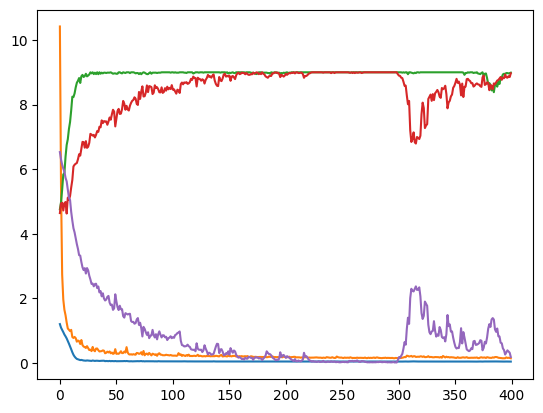

In [ ]:
import matplotlib.pyplot as plt
for idx in range(len(combined_loss[0,:])):
  if idx<5:
    plt.plot(combined_loss[:,idx])
    #print(combined_loss[:,idx])

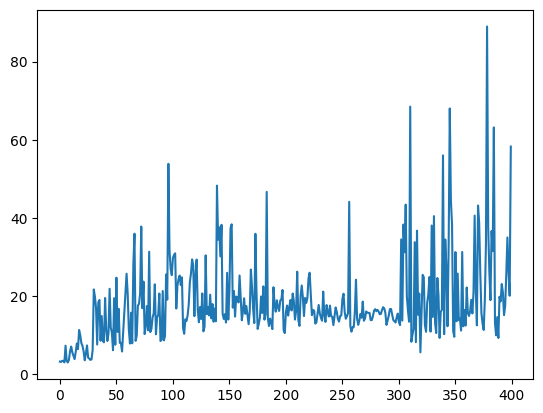

In [ ]:
plt.plot(combined_loss[:,5])

In [ ]:
#model_thick.load_state_dict(torch.load('/content/best-model_thick-parameters.pt'))
#model_area.load_state_dict(torch.load('/content/best-model_area-parameters.pt'))
#netClf.load_state_dict(torch.load('/content/best-netClf-parameters.pt'))
model_thick.load_state_dict(torch.load('/content/drive/MyDrive/BA/150epoch-model_thick-parameters.pt'))
model_area.load_state_dict(torch.load('/content/drive/MyDrive/BA/150epoch-model_area-parameters.pt'))
netClf.load_state_dict(torch.load('/content/drive/MyDrive/BA/150epoch-netClf-parameters.pt'))

<All keys matched successfully>

0.86625 693
[[393   5]
 [102 300]]


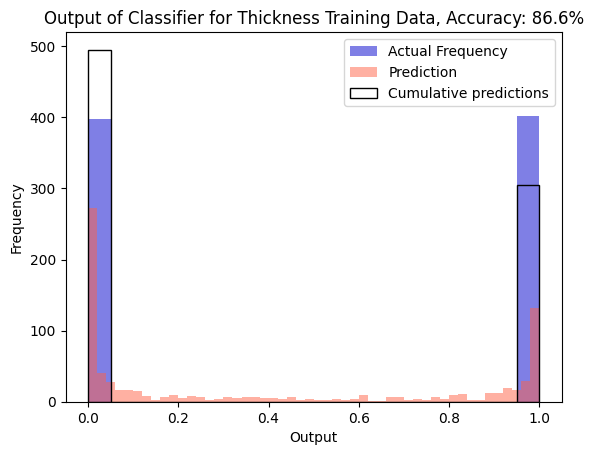

In [ ]:
model_thick.eval()
model_area.eval()
netClf.eval()
for batch_idx, samples in enumerate(train_dataloader):
      inputs_thick = samples[0]
      inputs_area=samples[1]
      y=samples[2]

      inputs_thick = inputs_thick.to(device)
      inputs_area=inputs_area.to(device)

      if batch_idx==0:
            thick_latent=model_thick.get_latent_var(x=inputs_thick)
            area_latent= model_area.get_latent_var(x=inputs_area)
            thick_prediction,_=netClf(thick_latent)
            area_prediction,_= netClf(area_latent)
            y_=y
      else:
            thick_latent_temp=model_thick.get_latent_var(x=inputs_thick)
            area_latent_temp= model_area.get_latent_var(x=inputs_area)

            thick_prediction_temp,_=netClf(thick_latent_temp)
            area_prediction_temp,_= netClf(area_latent_temp)

            thick_latent=torch.cat([thick_latent,thick_latent_temp])
            area_latent=torch.cat([area_latent,area_latent_temp])

            thick_prediction=torch.cat([thick_prediction,thick_prediction_temp])
            area_prediction=torch.cat([area_prediction,area_prediction_temp])

            y_=torch.cat([y_,y])

c=thick_prediction.cpu().detach()
c[np.where(c>0.5)]=1
c[np.where(c<0.5)]=0
list=0
for i,j in zip(c,y_.cpu().detach()):
  if i==j:
    list+=1
acc=list/len(c)
print(acc,list)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_, c.detach().cpu().numpy()))

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
plt.hist(y_,bins=20,color='mediumblue', alpha=0.5, label='Actual Frequency')
plt.hist(thick_prediction.cpu().detach().numpy(),bins=50,color='tomato', alpha=0.5, label='Prediction')
plt.hist(c.T,bins=20, facecolor="none",
              edgecolor='black', label='Cumulative predictions')
plt.legend()
plt.title('Output of Classifier for Thickness Training Data, Accuracy: '+ str(np.round(acc,decimals=3)*100)+'%')
plt.xlabel('Output')
plt.ylabel('Frequency')

plt.show()



Text(50.722222222222214, 0.5, 'Diagnosis')

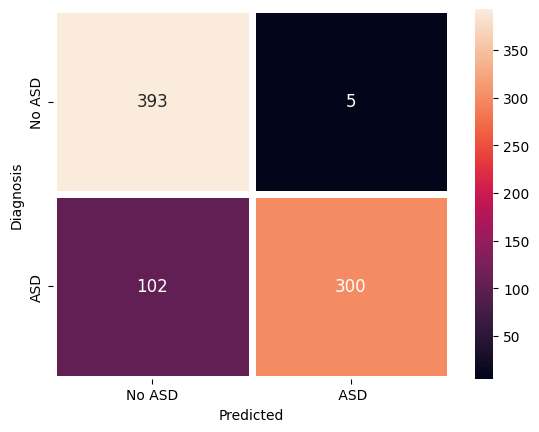

In [ ]:
import seaborn as sns
s=sns.heatmap(confusion_matrix(y_, c.detach().cpu().numpy()), annot=True, fmt='g', linewidth=5,xticklabels=[ 'No ASD',' ASD'], yticklabels= ['No ASD','ASD'], annot_kws={"size":12})
s.set_xlabel('Predicted', fontsize=10)
s.set_ylabel('Diagnosis', fontsize=10)

In [ ]:
y_.sum()

Text(0, 0.5, 'TSNE Component 2')

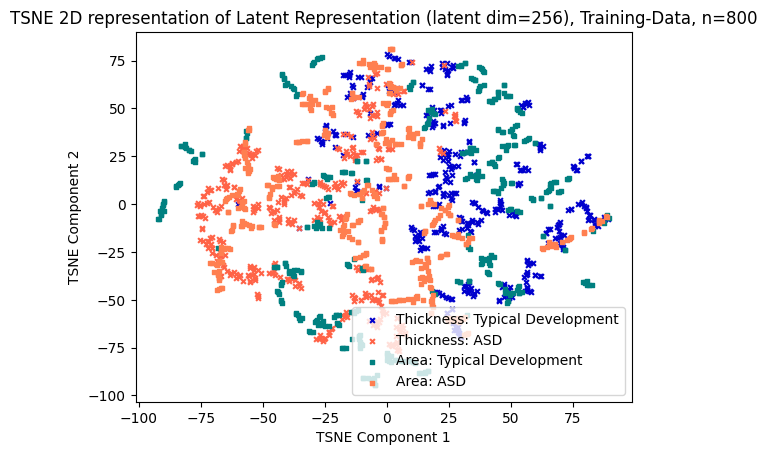

In [ ]:
from sklearn.manifold import TSNE

#area_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(area_latent.cpu().detach().numpy())
#X_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(thick_latent.cpu().detach().numpy())
plt.scatter(x=X_embedded[np.where(y_==0)][:,0],y=X_embedded[np.where(y_==0)][:,1],marker='x',label='Thickness: Typical Development',color='mediumblue', s=12)
plt.scatter(x=X_embedded[np.where(y_!=0)][:,0],y=X_embedded[np.where(y_!=0)][:,1],marker='x',label='Thickness: ASD',color='tomato', s=12)

plt.scatter(x=area_embedded[np.where(y_==0)][:,0],y=area_embedded[np.where(y_==0)][:,1],marker='s',label='Area: Typical Development',color='teal', s=12)
plt.scatter(x=area_embedded[np.where(y_!=0)][:,0],y=area_embedded[np.where(y_!=0)][:,1],marker='s',label='Area: ASD',color='coral', s=12)

plt.legend()
plt.title("TSNE 2D representation of Latent Representation (latent dim=256), Training-Data, n="+str(len(X_embedded[:,0])))
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")

In [ ]:
model_thick.eval()
model_area.eval()
netClf.eval()
for batch_idx, samples in enumerate(validation_dataloader):
      inputs = samples[0]
      y=samples[2]
      inputs = inputs.to(device)
      if batch_idx==0:
            thick_prediction_train,b=netClf(model_thick.get_latent_var(x=inputs))
            y_=y
      else:

            a1,b=netClf(model_thick.get_latent_var(x=inputs))
            thick_prediction_train=torch.cat([thick_prediction_train,a1])
            y_=torch.cat([y_,y])
            #print(a)

c=thick_prediction_train.cpu().detach()
c[np.where(c>0.5)]=1
c[np.where(c<0.5)]=0
list=0
for i,j in zip(c,y_.cpu().detach()):
  if i==j:
    list+=1
acc=list/len(c)
print(acc,list)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_, c.detach().cpu().numpy()))

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
plt.hist(y_,bins=20,color='mediumblue', alpha=0.5, label='Actual Frequency')
plt.hist(thick_prediction_train.cpu().detach().numpy(),bins=50,color='tomato', alpha=0.5, label='Prediction')
plt.hist(c.T,bins=20, facecolor="none",
              edgecolor='black', label='Cumulative predictions')
plt.legend()
plt.title('Output of Classifier for Thickness Test Data, Accuracy: '+ str(np.round(acc,decimals=3)*100)+'%, (n='+str(len(c))+')')
plt.xlabel('Output')
plt.ylabel('Frequency')

plt.show()


In [ ]:
model_thick.eval()
model_area.eval()
netClf.eval()
for batch_idx, samples in enumerate(validation_dataloader):
      inputs = samples[1]
      y=samples[2]
      inputs = inputs.to(device)
      if batch_idx==0:
            area_prediction_train,b=netClf(model_area.get_latent_var(x=inputs))
            y_=y
      else:

            a1,b=netClf(model_area.get_latent_var(x=inputs))
            area_prediction_train=torch.cat([area_prediction_train,a1])
            y_=torch.cat([y_,y])
            #print(a)

c=area_prediction_train.cpu().detach()
c[np.where(c>0.5)]=1
c[np.where(c<0.5)]=0
list=0
for i,j in zip(c,y_.cpu().detach()):
  if i==j:
    list+=1
acc=list/len(c)
print(acc,list)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_, c.detach().cpu().numpy()))

tensor(0.6600)

Text(0, 0.5, 'TSNE Component 2')

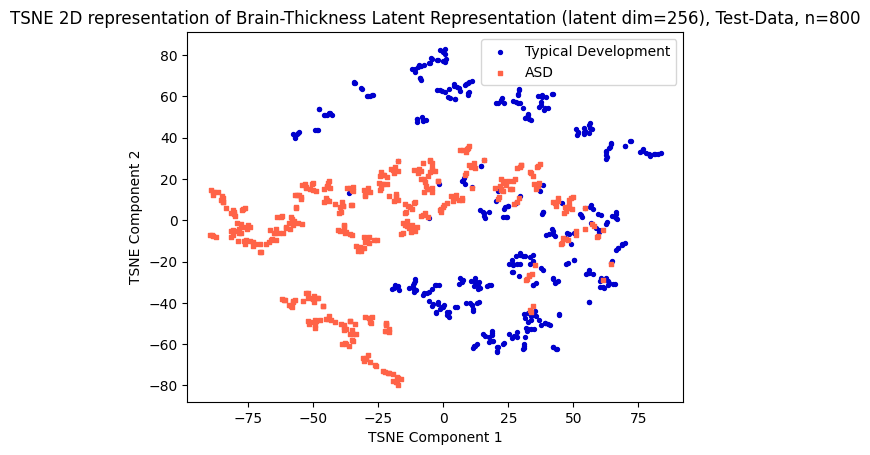

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(thick_latent.cpu().detach().numpy())
plt.scatter(x=X_embedded[np.where(y_==0)][:,0],y=X_embedded[np.where(y_==0)][:,1],marker='o',label='Typical Development',color='mediumblue', s=8)
plt.scatter(x=X_embedded[np.where(y_!=0)][:,0],y=X_embedded[np.where(y_!=0)][:,1],marker='s',label='ASD',color='tomato', s=8)
plt.legend()
plt.title("TSNE 2D representation of Brain-Thickness Latent Representation (latent dim=256), Test-Data, n="+str(len(y_)))
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")

Text(50.722222222222214, 0.5, 'Diagnosis')

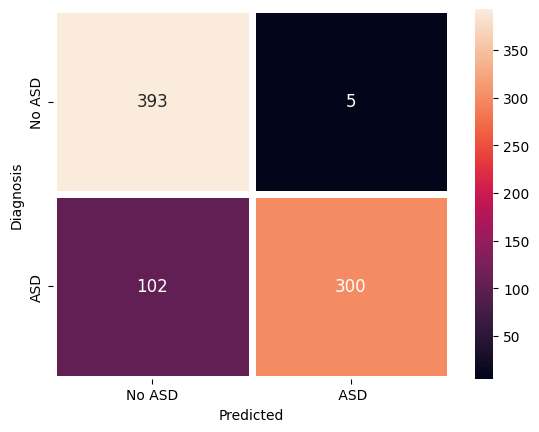

In [ ]:
import seaborn as sns
s=sns.heatmap(confusion_matrix(y_, c.detach().cpu().numpy()), annot=True, fmt='g', linewidth=5,xticklabels=[ 'No ASD',' ASD'], yticklabels= ['No ASD','ASD'], annot_kws={"size":12})
s.set_xlabel('Predicted', fontsize=10)
s.set_ylabel('Diagnosis', fontsize=10)

In [ ]:
!pip install nilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 90.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 74.6 MB/s eta 0:00:00
  Attempting uninstall: nibabel
    Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2


In [ ]:

  for idx, samples in enumerate(train_dataloader):
      thick_test_inputs = samples[0].to(device)
      labels = samples[2].to(device)
      area_test_inputs = samples[1].to(device)

      loss=criterion_reconstruct(model_area.decode(model_thick.get_latent_var(thick_test_inputs)),area_test_inputs)
      if idx==0:
        b=model_area.decode(model_thick.get_latent_var(thick_test_inputs))-area_test_inputs
      else:
        b=torch.cat((b,model_area.decode(model_thick.get_latent_var(thick_test_inputs))-area_test_inputs),0)

from nilearn import datasets

fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage')
from nilearn import plotting
#mean=(mean/len(X_embedded))
plotting.plot_surf_stat_map(fsaverage.white_left,torch.mean(b,0).cpu().detach().numpy() ,title=f"Surface left hemisphere, Translation Loss, Training, Standard Dev. Reconstruction,: "+str(np.round(np.std(b.cpu().detach().numpy()),4)))

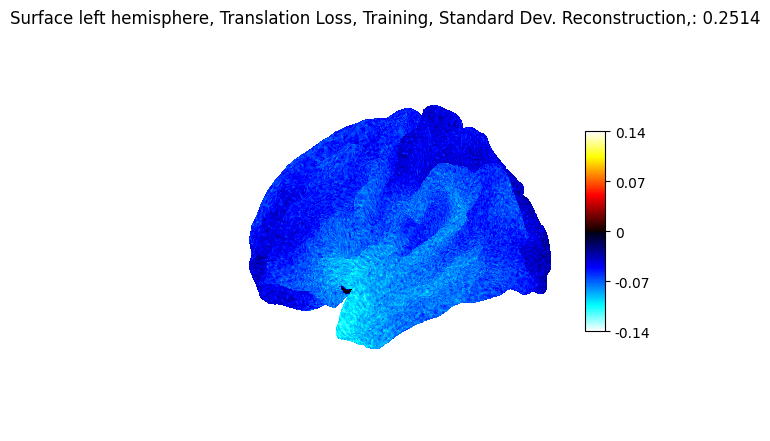

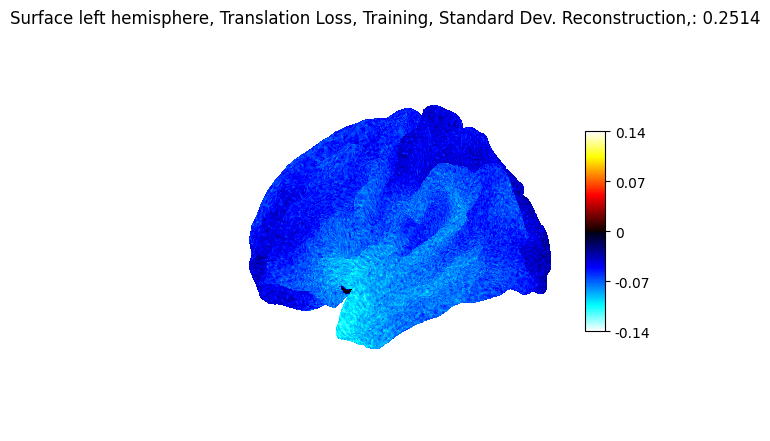

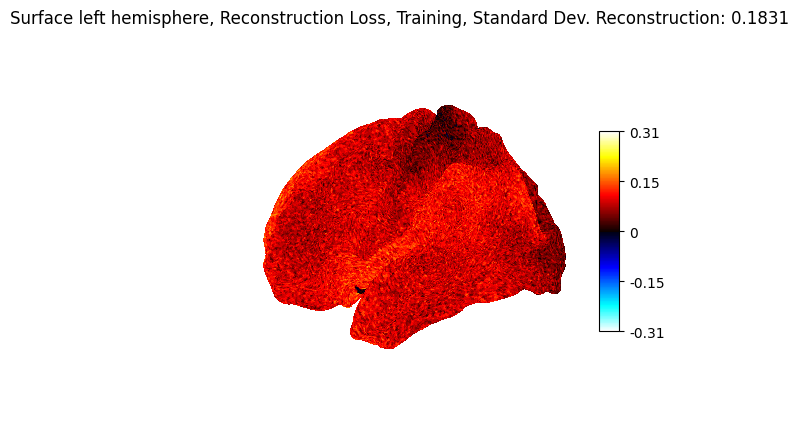

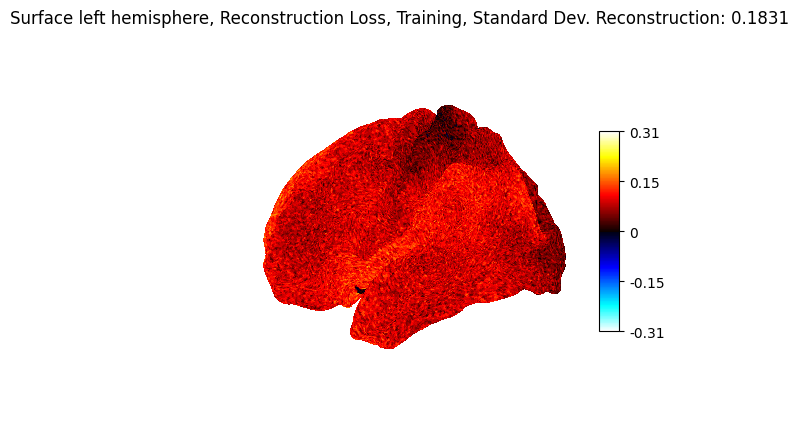

In [ ]:

  for idx, samples in enumerate(train_dataloader):
      thick_test_inputs = samples[0].to(device)
      labels = samples[2].to(device)
      area_train_inputs = samples[1].to(device)
      if idx==0:
        thick_recon,_,_, _ = model_area(area_train_inputs)
        b=(area_train_inputs-thick_recon)
      else:
        thick_recon,_,_, _ = model_area(area_train_inputs)
        b=torch.cat((b,area_train_inputs-thick_recon),0)

plotting.plot_surf_stat_map(fsaverage.white_left,torch.mean(b,0).cpu().detach().numpy() ,title=f"Surface left hemisphere, Reconstruction Loss, Training, Standard Dev. Reconstruction: "+str(np.round(np.std(b.cpu().detach().numpy()),4)))

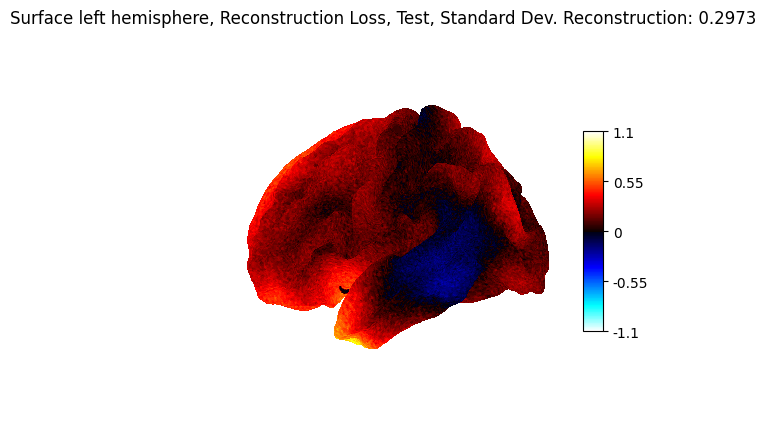

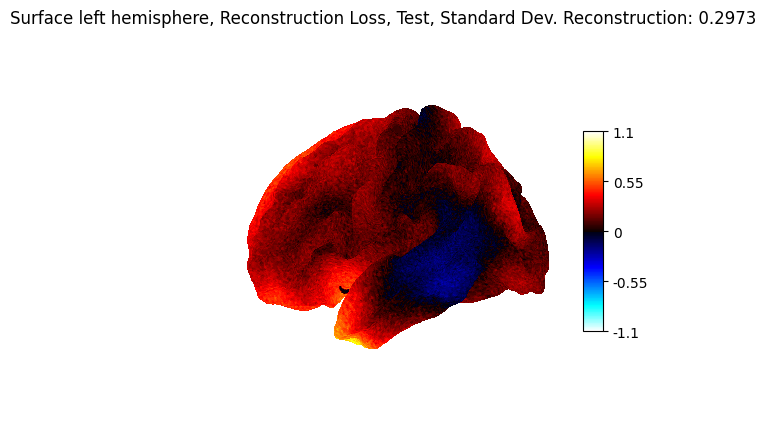

In [ ]:

for idx, samples in enumerate(test_dataloader):
    thick_test_inputs = samples[0].to(device)
    labels = samples[2].to(device)
    area_test_inputs = samples[1].to(device)

    if idx==0:
      thick_recon,_,_, _ = model_area(area_test_inputs)
      b=(area_test_inputs-thick_recon)
    else:
      thick_recon,_,_, _ = model_area(area_test_inputs)
      b=torch.cat(b,(area_test_inputs-thick_recon),0)

plotting.plot_surf_stat_map(fsaverage.white_left,torch.mean(b,0).cpu().detach().numpy() ,title=f"Surface left hemisphere, Reconstruction Loss, Test, Standard Dev. Reconstruction: "+str(np.round(np.std(b.cpu().detach().numpy()),4)))

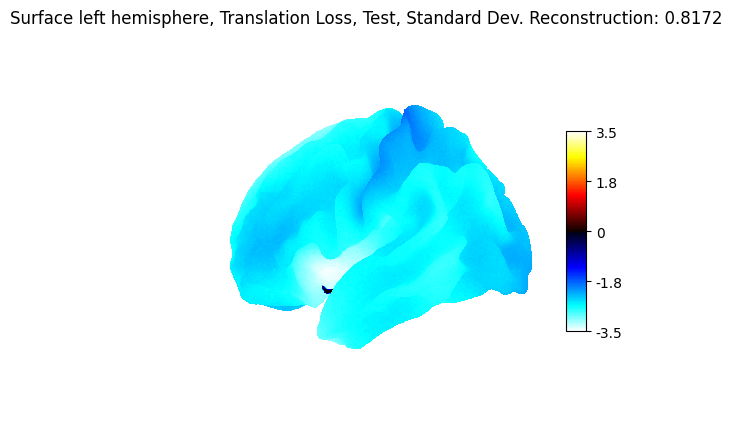

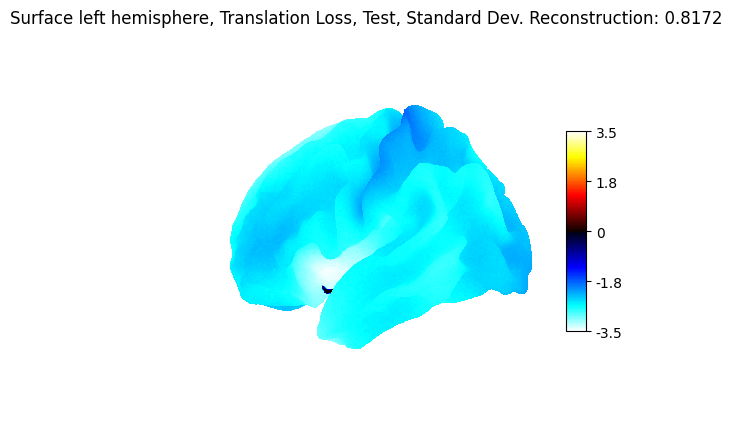

In [ ]:

for idx, samples in enumerate(test_dataloader):
    thick_test_inputs = samples[0].to(device)
    labels = samples[2].to(device)
    area_test_inputs = samples[1].to(device)

    loss=criterion_reconstruct(model_area.decode(model_thick.get_latent_var(thick_test_inputs)),area_test_inputs)
    if idx==0:
      b=area_test_inputs-model_area.decode(model_thick.get_latent_var(thick_test_inputs))-area_test_inputs
    else:
      b=torch.cat((b,area_test_inputs-model_area.decode(model_thick.get_latent_var(thick_test_inputs))),0)



plotting.plot_surf_stat_map(fsaverage.white_left,torch.mean(b,0).cpu().detach().numpy() ,title=f"Surface left hemisphere, Translation Loss, Test, Standard Dev. Reconstruction: "+str(np.round(np.std(b.cpu().detach().numpy()),4)))

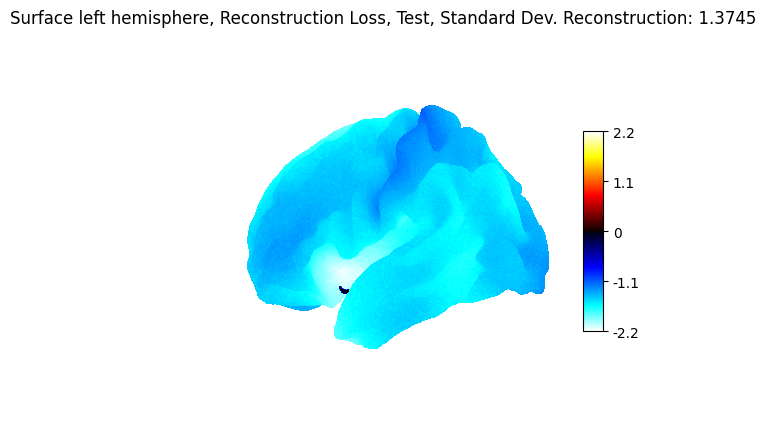

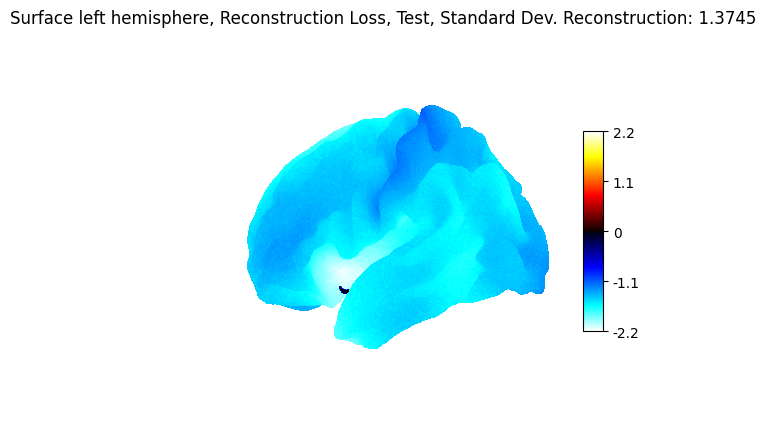

In [ ]:

for idx, samples in enumerate(validation_dataloader):
    thick_test_inputs = samples[0].to(device)
    labels = samples[2].to(device)
    area_test_inputs = samples[1].to(device)

    loss=criterion_reconstruct(model_area.decode(model_thick.get_latent_var(thick_test_inputs)),area_test_inputs)
    if idx==0:
      b=area_test_inputs-model_area.decode(model_thick.get_latent_var(thick_test_inputs))-area_test_inputs
    else:
      b=torch.cat((b,area_test_inputs-model_area.decode(model_thick.get_latent_var(thick_test_inputs))),0)



plotting.plot_surf_stat_map(fsaverage.white_left,torch.mean(b,0).cpu().detach().numpy() ,title=f"Surface left hemisphere, Reconstruction Loss, Test, Standard Dev. Reconstruction: "+str(np.round(np.std(b.cpu().detach().numpy()),4)))

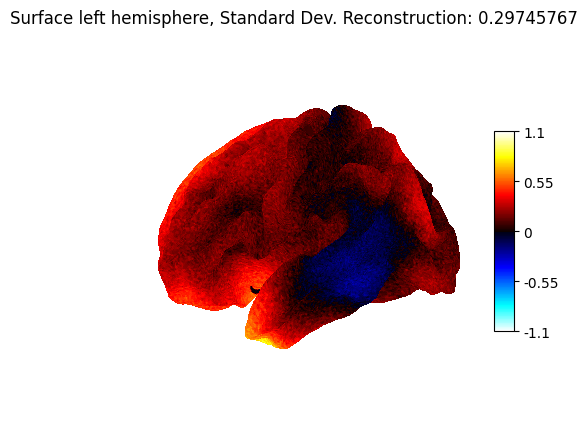

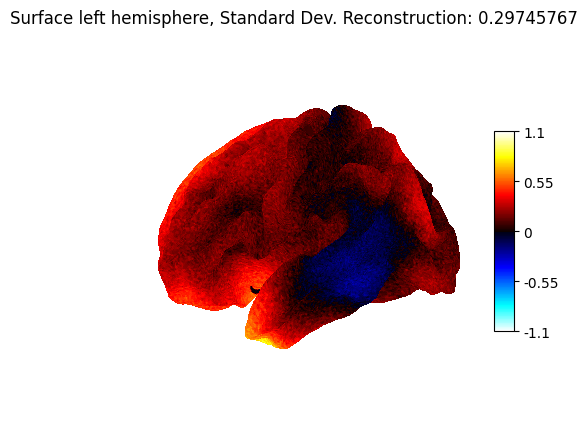

In [ ]:

from nilearn import datasets

fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage')
from nilearn import plotting
#mean=(mean/len(X_embedded))
plotting.plot_surf_stat_map(fsaverage.white_left,torch.mean(b,0).cpu().detach().numpy() ,title=f"Surface left hemisphere, Standard Dev. Reconstruction: "+str(np.std(b.cpu().detach().numpy())))


In [ ]:
torch.mean(b)

tensor(-0.0072, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
fsaverage.white_left

In [ ]:
data_area=np.concatenate((np.load('/content/drive/My Drive/BA/train_data_area.npy')[:,:,0].T, np.load('/content/drive/My Drive/BA/test_data_area.npy')[:,:,0].T),axis=0)



In [ ]:
data_area_mean=np.full(shape=data_area.shape,fill_value=np.mean(data_area))
print(data_area_mean.shape,data_area.shape)
print(np.sqrt(np.sum((data_area-data_area_mean)**2)/len(data_area[:,0])))

(1033, 163842) (1033, 163842)
87.45182004969121


In [ ]:
np.mean(np.abs(b.cpu().detach().numpy()))

0.29740542